# Predicting New York Times Daily Top 20 Most Shared Articles on Facebook

In [89]:
# file manipulation 
import os

# data manipulation 
import re
import datetime as dt
import pandas as pd
import numpy as np
import math
from functions import *

# modeling 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, plot_confusion_matrix, plot_roc_curve

# sampling
from imblearn.over_sampling import SMOTE

# preprocessing text
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 


# plotting 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

#### Loading the data
The scripts to request, clean and store both the article archive data and the daily top 20 most shared on Facebook lists can be found in [request_archive.py](./request_archive.py) and [request_most_shared_articles.py](./request_most_shared_articles.py). One request for a top 20 list for the previous 30 days was made to help label some articles in the archive as popular that were published before daily collection of a top 20 list was begun. 

The archive data contains all articles from December and all from January up to the end of the training phase on January 15th. Any rows with Null values in the archive were dropped and the date published column was changed to the datetime data type. The metadate that was collected for modeling was the headline of the article, keywords for the article, a snippet from the article and the word count for the article. Additionally the URI and date published was grabbed for each article. 

For each top 20 list the URI, date published and date the list was sourced was taken. 

In [90]:
# load archive articles from csv in data directory
df = pd.read_csv('data/archive_train.csv')
df.date_published = df.date_published.apply(lambda x: pd.to_datetime(x).date())
df.dropna(inplace=True)

# load seperate top 20 lists in folder in data directory into single dataframe 
df_most_shared = load_most_shared('data/most_popular_train')

<br>
A list was made to house the URI's, the unique index for each article, for articles appearing on a top 20 list at least once. Then a popular column was created for the archive dataframe by iterating over the list of the highly shared articles and assigning a 0 if that article's URI was not present on the list and 1 for if it was. This is the target column for the models.

In [91]:
# create list, then interate over it to make target column
popular_list = df_most_shared.uri.values
df['popular'] = [1 if x in popular_list else 0 for x in df.uri.values]

In [92]:
# view the dataframe
df.head()

,uri,date_published,headline,keywords,snippet,paragraph,word_count,popular
0,nyt://article/4e2abcbc-9563-56c0-bf18-c93ce4e7...,2021-12-01,let’s end the covid blame games,coronavirus omicron variantcoronavirus (2019-n...,"Finger pointing is pointless, divisive and dumb.","over the summer, as covid cases started rising...",918,0
1,nyt://article/f7a5e7ef-e4cd-575c-a0e1-ff4d18d5...,2021-12-01,trump’s iran policy has become a disaster for ...,irannuclear weaponsembargoes and sanctionsunit...,Withdrawing from the Iran nuclear deal was a m...,the judges have voted and the results are in: ...,1560,0
2,nyt://article/778af86c-b600-5aeb-be98-0a9a1aa1...,2021-12-01,this extinct eagle may have gulped guts like a...,eagles (birds)vultures (birds)condorsendangere...,Scientists suggest the largest eagle that ever...,"at craigmore station in canterbury, new zealan...",913,0
3,nyt://article/fb7763c2-0f41-5c81-9ecf-17607ba5...,2021-12-01,republican recriminations point to a rocky pat...,republican partyhouse of representativesboeber...,Simmering tensions between the far-right flank...,washington — hostilities between the republica...,1172,0
4,nyt://article/ba0afd37-0c00-5535-8868-21130e28...,2021-12-01,a times editor who attended oxford recalls a d...,school shootings and armed attacks,Three teenage students were killed on Tuesday ...,the last time i was inside the walls of oxford...,309,0


## Exploratory Data Analysis  
Checking `df.info()` shows that both DataFrame individually have equal values with no Null values to take care of. It also shows that the datatypes are what we expect and want. 

In [93]:
print(df.info())
print()
print(df_most_shared.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5198 entries, 0 to 5795
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uri             5198 non-null   object
 1   date_published  5198 non-null   object
 2   headline        5198 non-null   object
 3   keywords        5198 non-null   object
 4   snippet         5198 non-null   object
 5   paragraph       5198 non-null   object
 6   word_count      5198 non-null   int64 
 7   popular         5198 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 365.5+ KB
None

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 2022-01-18 to 2022-01-10
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uri             200 non-null    object
 1   date_published  200 non-null    object
dtypes: object(2)
memory usage: 4.7+ KB
None


##### Archive articles
Looking at the distribution of article popularity reveals massive class imbalance. Only 2% of the articles in the archive appear on a top 20 list. This is particularly because of the articles included in the archive that were published in December and January before daily top 20 lists were started to be collected. Due to the API's constraints, only the daily top 20 list from the day the request was made are available. 

,sum,percentage
popular,,
0,5061,0.97
1,137,0.03


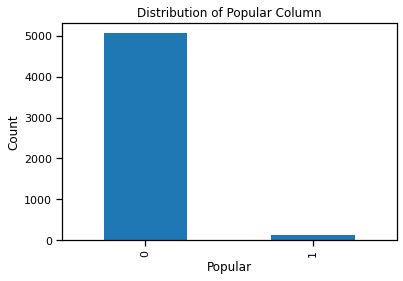

In [94]:
# function makes a dataframe to display target variable value's sum and percentage
# also, it plots the target variable's value distribution
target_distribution = summerize_value_counts(df.popular)
target_distribution

##### Top 20 most shared articles
Looking at each day's top 20 list and the distribution of dates when the articles were published originally shows that the majority of the articles on each list were published in the two days before the day of the list's creation, with a smaller proportion having been published three days before or on the day of creation.

functions used to load, clean and plot the date are found in [functions.py](./functions.py).

In [95]:
# load csv's into a list of dataframes 
df_list_load = load_most_shared_eda('data/most_popular_train')

# change date columns to datetime dtype and sort list by date of top 20 list in ascending order 
df_list = clean_most_shared_eda(df_list_load)

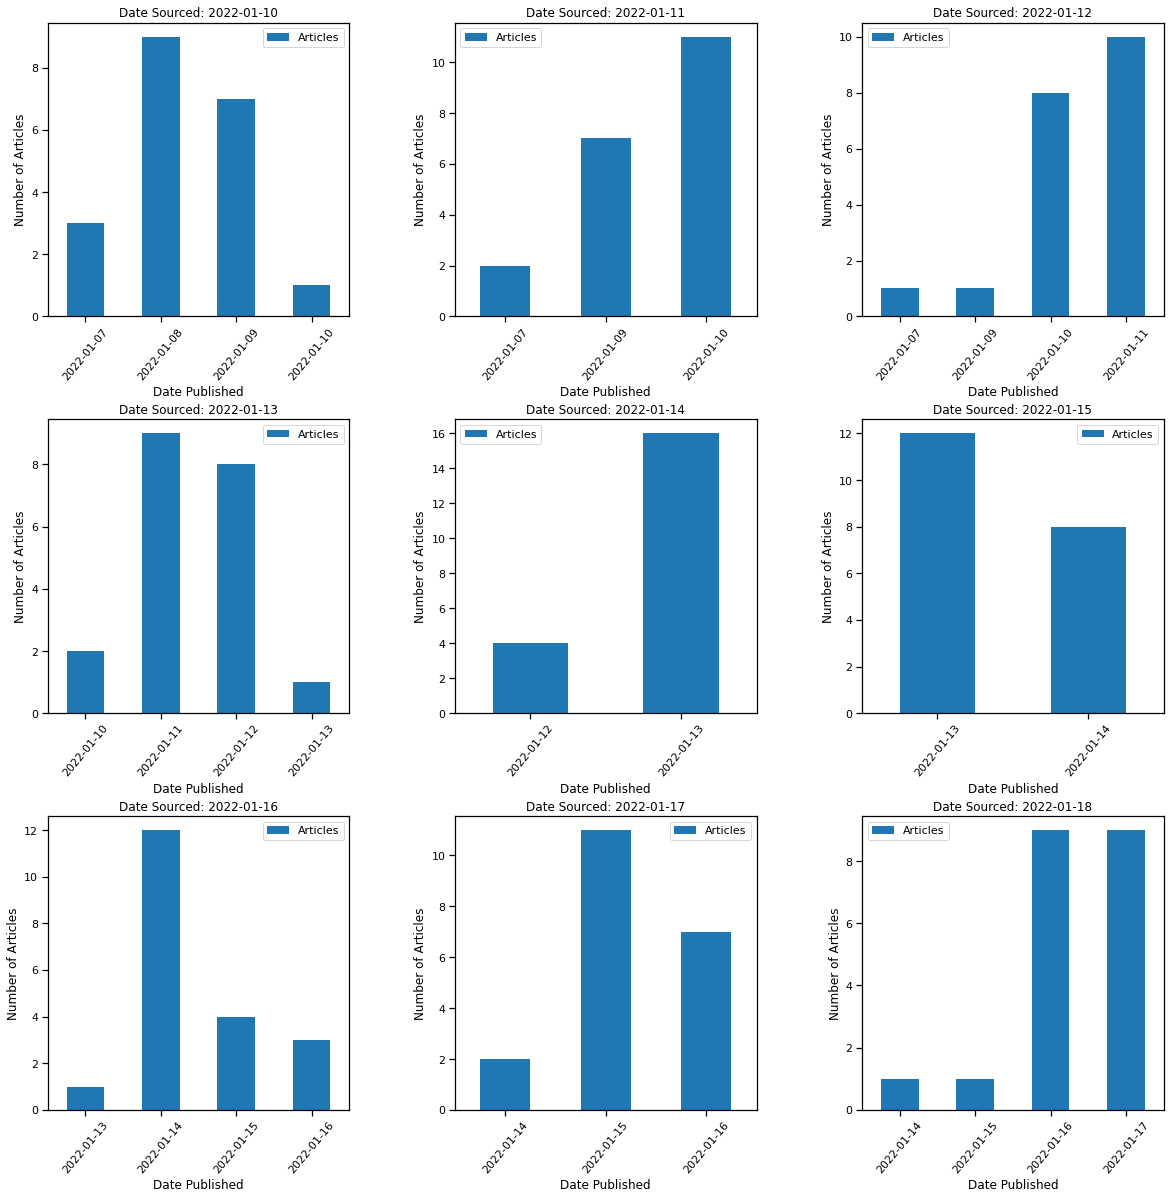

In [96]:
# generate correct amount of subplots based on length of list then plot each dataframe in list
plot_most_shared(df_list)

,percentage
0 days,3%
1 days,44%
2 days,45%
3 days,6%
4 days,2%
5 days,1%


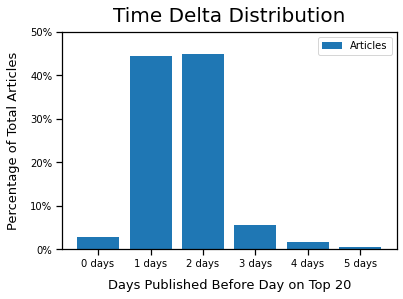

In [97]:
time_delta, top_20_df = top_20_delta_perc(df_list)
top_20_df

## Data Preperation

##### Train-Test Split
Features are separated from the target and a test size of 40% is selected. This is because the final model is trained with the testing data results of the models before it. To ensure it has enough training data, a relatively high test size proportion was chosen. 

Also, the random state is established as 0, which will be the state for all models going forward. 

In [98]:
# headline tfidf winners: headline_tf, headline_proba_rf, headline_proba
# headline cv winners: headline_cv, headline_class_rf, headline_class

In [99]:
# keywords tfidf winners: keywords_tf, keywords_proba_rf, keywords_proba
# keywords cv winners: keywords_cv, keywords_class_rf, keywords_class

In [100]:
# snippet tfidf winners: snippet_tok_tf, snippet_proba_rf_tok, snippet_proba_tok
# snippet cv winners: snippet_tok_cv, snippet_class_rf_tok, snippet_class_tok

In [101]:
# features = X, target = y
X = df.drop('popular', axis=1)
y = df.popular

In [102]:
sw = stopwords.words('english')

In [103]:

headline_tf = TfidfVectorizer(stop_words=sw)
keywords_tf = TfidfVectorizer(stop_words=sw)


headline_tf_vec = headline_tf.fit_transform(X.headline)
keywords_tf_vec = keywords_tf.fit_transform(X.keywords)

In [104]:

headline_cv = CountVectorizer(stop_words=sw)
keywords_cv = CountVectorizer(stop_words=sw)


headline_cv_vec = headline_cv.fit_transform(X.headline)
keywords_cv_vec = keywords_cv.fit_transform(X.keywords)

In [105]:
# param headline: a single headline
# return: a headline string with words which have been lemmatized, parsed for 
# stopwords and stripped of punctuation and numbers.
def text_prep(text, sw):
    
    sw = stopwords.words('english')
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    text = regex_token.tokenize(text)
    text = [word for word in text]
    text = [word for word in text if word not in sw]
    text = pos_tag(text)
    text = [(word[0], get_wordnet_pos(word[1])) for word in text]
    lemmatizer = WordNetLemmatizer() 
    text = [lemmatizer.lemmatize(word[0], word[1]) for word in text]
    return ' '.join(text)


In [106]:
def lemmatize_vector(vectorizer, X):
    
    sw = stopwords.words('english')
    vectorizer = vectorizer(stop_words=sw)
    
    X_lem = [text_prep(text, sw) for text in X]
    X_vec_lem = vectorizer.fit_transform(X_lem)
    
    return vectorizer, X_vec_lem

In [107]:
snippet_tf_lem, snippet_tf_lem_vec =  lemmatize_vector(TfidfVectorizer, X.snippet)

paragraph_tf_lem, paragraph_tf_lem_vec =  lemmatize_vector(TfidfVectorizer, X.paragraph)

In [108]:
snippet_cv_lem, snippet_cv_lem_vec =  lemmatize_vector(CountVectorizer, X.snippet)

paragraph_cv_lem, paragraph_cv_lem_vec =  lemmatize_vector(CountVectorizer, X.paragraph)

## Model Training - Text Features

### Healdine

##### TfidfVectorizer

In [109]:
# train random forrest
headline_rf_tf = RandomForestClassifier(n_estimators=75, random_state=0)
headline_rf_tf.fit(headline_tf_vec, y)

RandomForestClassifier(n_estimators=75, random_state=0)

##### CountVectoizer

In [110]:
# train random forrest
headline_rf_cv = RandomForestClassifier(n_estimators=75, random_state=0)
headline_rf_cv.fit(headline_cv_vec, y)

RandomForestClassifier(n_estimators=75, random_state=0)

### Keywords

##### Predict Probability after TfidfVectorizer

In [111]:
# train random forrest
keywords_rf_tf = RandomForestClassifier(random_state=0)
keywords_rf_tf.fit(keywords_tf_vec, y)

RandomForestClassifier(random_state=0)

##### Predict Class after CountVectorizer

In [112]:
# train random forrest
keywords_rf_cv = RandomForestClassifier(random_state=0)
keywords_rf_cv.fit(keywords_cv_vec, y)

RandomForestClassifier(random_state=0)

### Snippet 

In [113]:
# train random forrest
snippet_rf_tf = RandomForestClassifier(random_state=0)
snippet_rf_tf.fit(snippet_tf_lem_vec, y)

RandomForestClassifier(random_state=0)

In [114]:
# train random forrest
snippet_rf_cv = RandomForestClassifier(random_state=0)
snippet_rf_cv.fit(snippet_cv_lem_vec, y)

RandomForestClassifier(random_state=0)

### Paragraph

In [115]:
# train random forrest
paragraph_rf_tf = RandomForestClassifier(random_state=0)
paragraph_rf_tf.fit(paragraph_tf_lem_vec, y)

RandomForestClassifier(random_state=0)

In [116]:
# train random forrest
paragraph_rf_cv = RandomForestClassifier(random_state=0)
paragraph_rf_cv.fit(paragraph_cv_lem_vec, y)

RandomForestClassifier(random_state=0)

### Word Count

In [166]:
wc_clf = LogisticRegression(random_state=0)
wc_clf.fit(X.word_count.values.reshape(-1, 1), y)

LogisticRegression(random_state=0)

## Cumulative Model 

### Cleaning 

##### Proability Data

In [141]:
df_predict_proba = pd.DataFrame({'headline_prob': headline_proba, 
                                 'keywords_prob': keywords_proba, 
                                 'snippet_prob': snippet_proba_tok, 
                                 'word_count_prob': word_count_proba})

In [142]:
df_predict_proba.head()

,headline_prob,keywords_prob,snippet_prob,word_count_prob
0,0.000000,0.00,0.00,0.503994
1,0.040000,0.04,0.04,0.518280
2,0.093333,0.13,0.00,0.508021
3,0.000000,0.02,0.02,0.469248
4,0.013333,0.12,0.02,0.508811


In [143]:
scaler = StandardScaler()

In [144]:
df_predict_proba.iloc[:,:] = scaler.fit_transform(df_predict_proba.iloc[:,:].to_numpy())

In [145]:
df_predict_proba.head()

,headline_prob,keywords_prob,snippet_prob,word_count_prob
0,-0.499462,-0.568664,-0.648480,0.188469
1,0.307332,0.238133,0.365473,0.710926
2,1.383058,2.053428,-0.648480,0.335742
3,-0.499462,-0.165265,-0.141504,-1.082329
4,-0.230530,1.851728,-0.141504,0.364615


In [146]:
df_predict_proba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   headline_prob    2164 non-null   float64
 1   keywords_prob    2164 non-null   float64
 2   snippet_prob     2164 non-null   float64
 3   word_count_prob  2164 non-null   float64
dtypes: float64(4)
memory usage: 67.8 KB


<br>

##### Class Labeled Data 

In [147]:
df_predict_class = pd.DataFrame({'headline_prob': headline_class, 
                                 'keywords_prob': keywords_class, 
                                 'snippet_prob': snippet_class_tok, 
                                 'word_count_class': word_count_class})

In [148]:
df_predict_class.head()

,headline_prob,keywords_prob,snippet_prob,word_count_class
0,1,0,0,1
1,0,0,0,1
2,1,0,0,1
3,1,0,1,0
4,0,0,0,1


In [149]:
df_predict_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   headline_prob     2164 non-null   int64
 1   keywords_prob     2164 non-null   int64
 2   snippet_prob      2164 non-null   int64
 3   word_count_class  2164 non-null   int64
dtypes: int64(4)
memory usage: 67.8 KB


<br>

### Training model

,sum,percentage
popular,,
0,2102,0.97
1,62,0.03


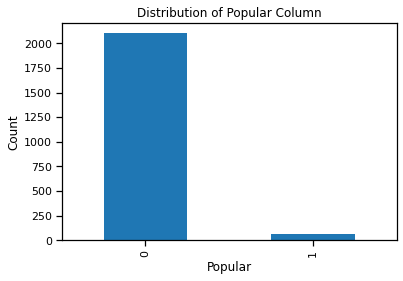

In [150]:
target_distribution_deploy = summerize_value_counts(y_test)
target_distribution_deploy



##### Predicting with Probabilities 

In [151]:
clf_proba = LogisticRegression()

In [152]:
clf_proba.fit(df_predict_proba, y_test)

LogisticRegression()

<br>

##### Predicitng with class labels

In [153]:
clf_class = LogisticRegression()

In [154]:
clf_class.fit(df_predict_class, y_test)

LogisticRegression()

## Model Deployment

In [167]:
df_archive_deploy = pd.read_csv('data/archive_deploy.csv')
df_archive_deploy.date_published = df_archive_deploy.date_published.apply(lambda x: pd.to_datetime(x).date())
df_archive_deploy.dropna(inplace=True)

df_most_shared_deploy = load_most_shared('data/most_popular_deploy')

In [168]:
prediction_day = '01/19/22'
prediction_day = pd.to_datetime(prediction_day).date()
prediction_day

datetime.date(2022, 1, 19)

In [169]:
delta_dict = time_delta.to_dict()
delta_dict

{Timedelta('0 days 00:00:00'): 0.0278,
 Timedelta('1 days 00:00:00'): 0.4444,
 Timedelta('2 days 00:00:00'): 0.45,
 Timedelta('3 days 00:00:00'): 0.0556,
 Timedelta('4 days 00:00:00'): 0.0167,
 Timedelta('5 days 00:00:00'): 0.0056}

In [170]:
def filter_predction_dfs(df_archive, df_shared, day_of_predict, delta=3):
    
    time_delta = dt.timedelta(days=delta)
    cutoff_day = day_of_predict - time_delta
    
    df_deploy = df_archive[(df_archive.date_published >= cutoff_day) & 
                             (df_archive.date_published <= day_of_predict)]
    
    article_ids = df_deploy['uri']
    date_published = df_deploy['date_published']
#     delta_correction = [delta_dict[abs(x - prediction_day)] for x in test.date_published]
    df_feature_deploy = df_deploy[['headline','keywords','snippet', 'paragraph', 'word_count']]
    
    df_top_20 = df_shared[df_shared.index == day_of_predict]
    
    return article_ids, date_published, df_feature_deploy, df_top_20

In [171]:
deployed_article_ids, date_published, df_feature_deploy, df_top_20 = filter_predction_dfs(df_archive_deploy, 
                                                                          df_most_shared_deploy, 
                                                                          prediction_day, delta=3)

In [172]:
deployed_article_ids

2      nyt://article/f00468d9-8c85-5141-a5a4-8b592f6a...
5      nyt://article/45bfef70-a4e6-5211-b9f4-95c9acfc...
6      nyt://article/09084cca-4f23-5fb1-8d82-5c01e336...
7      nyt://article/ad52d330-1f21-51a4-98d0-b2b355d0...
8      nyt://article/0b4e771d-ff07-5c67-98f5-4b1c0a7a...
                             ...                        
450    nyt://article/351e4921-0c01-57f1-97fa-8f5b688f...
451    nyt://article/8244b19f-6ec1-5d2f-9d63-50c1b33e...
452    nyt://article/d74b169c-2fa1-5f3e-96d9-d8f26f0a...
453    nyt://article/d8ddfe47-3836-5a89-8761-64ad6ed3...
454    nyt://interactive/94a3f735-2139-5b18-a23d-4386...
Name: uri, Length: 415, dtype: object

In [173]:
date_published.value_counts().sum()

415

In [174]:
df_feature_deploy.shape

(415, 5)

In [175]:
def predict_with_probabilities():
    
    headline = df.headline
    keywords = df.keywords
    snippet = df.snippet
    word_count = df.word_count
    
    headline_tf_vec.transform()
    headline_tf_vec_tok.transform()
    headline_proba_rf.predict_proba()
    
    keywords_tf_vec.transform
    keywords_tf_vec_tok.transform
    keywords_proba_rf.predict_proba
    
    snippet_tf_vec.transform
    snippet_tf_vec_tok.transform
    snippet_proba_rf.predict_proba
    
    word_count_log_reg.predict_proba

    

In [176]:
def predict_with_class_labels(df):
    
    headline = df.headline
    keywords = df.keywords
    snippet = df.snippet
    word_count = df.word_count
    
    headline_cv_vec.transform
    headline_cv_vec_tok.transform
    headline_class_rf.predict
    
    keywords_cv_vec.transform
    keywords_cv_vec_tok.transform
    keywords_class_rf.predict
    
    snippet_cv_vec.transform
    snippet_cv_vec_tok.transform
    snippet_class_rf.predict
    
    word_count_log_reg.predict
    
    

In [177]:
headline_proba_pipe = Pipeline([('headline_tf', headline_tf), 
                                ('headline_proba_rf', headline_rf_tf)])

In [178]:
keywords_proba_pipe = Pipeline([('keywords_tf', keywords_tf), 
                                ('keywords_proba_rf', keywords_rf_tf)])

In [179]:
snippet_proba_pipe = Pipeline([('snippet_tok_tf', snippet_tf_lem), 
                               ('snippet_proba_rf_tok', snippet_rf_tf)])

In [180]:
paragraph_proba_pipe = Pipeline([('paragraph_cv_lem', paragraph_cv_lem), 
                               ('paragraph_rf_cv', paragraph_rf_cv)])

In [181]:
def proba_nlp_pipeline(features, index):
    
    headline_probs = headline_proba_pipe.predict_proba(features.headline)
    headline_probs = [x[1] for x in headline_probs]
    
    keywords_probs = keywords_proba_pipe.predict_proba(features.keywords)
    keywords_probs = [x[1] for x in keywords_probs]
    
    snippet_probs  = snippet_proba_pipe.predict_proba(features.snippet)
    snippet_probs = [x[1] for x in snippet_probs]
    
    word_count_probs = wc_clf.predict_proba(features.word_count.values.reshape(-1, 1))
    word_count_probs = [x[1] for x in word_count_probs]
    
    paragraph_probs  = paragraph_proba_pipe.predict_proba(features.paragraph)
    paragraph_probs = [x[1] for x in paragraph_probs]  
    
    
    df = pd.DataFrame({'headline_probabilty': headline_probs, 
                       'keywords_probabilty': keywords_probs,
                       'snippet_probabilty': snippet_probs, 
                       'paragraph_probs': paragraph_probs,
                       'word_count_probabilty': word_count_probs}, index=index)
        
    scaler = StandardScaler()
    df.iloc[:, :] = scaler.fit_transform(df.iloc[:, :].to_numpy())
    
    return df

In [182]:
# test_df = pd.DataFrame(tree_details.values(), index=tree_details.keys(), columns=['Information'])

In [183]:
# headline tfidf winners: headline_tf, headline_proba_rf, headline_proba
# headline cv winners: headline_cv, headline_class_rf, headline_class

In [184]:
# keywords tfidf winners: keywords_tf, keywords_proba_rf, keywords_proba
# keywords cv winners: keywords_cv, keywords_class_rf, keywords_class

In [185]:
# snippet tfidf winners: snippet_tok_tf, snippet_proba_rf_tok, snippet_proba_tok
# snippet cv winners: snippet_tok_cv, snippet_class_rf_tok, snippet_class_tok

In [186]:
headline_class_pipe = Pipeline([('headline_cv', headline_cv), 
                                ('headline_rf_cv', headline_rf_cv)])

In [187]:
keywords_class_pipe = Pipeline([('keywords_cv', keywords_cv), 
                                ('keywords_rf_cv', keywords_rf_cv)])

In [188]:
snippet_class_pipe = Pipeline([('snippet_cv_lem', snippet_cv_lem), 
                               ('snippet_rf_cv', snippet_rf_cv)])

In [189]:
paragraph_class_pipe = Pipeline([('paragraph_cv_lem', paragraph_cv_lem), 
                               ('paragraph_rf_cv', paragraph_rf_cv)])

In [190]:
def class_nlp_pipeline(features, index):
    
    headline_probs = headline_class_pipe.predict(features.headline)
    keywords_probs = keywords_class_pipe.predict(features.keywords)
    snippet_probs  = snippet_class_pipe.predict(features.snippet)
    paragraph_probs  = paragraph_class_pipe.predict(features.paragraph)
    word_count_probs = wc_clf.predict(features.word_count.values.reshape(-1, 1))
    
    df = pd.DataFrame({'headline_probabilty': headline_probs, 
                       'keywords_probabilty': keywords_probs, 
                       'snippet_probabilty': snippet_probs, 
                       'paragraph_probs': paragraph_probs,
                       'word_count_probabilty': word_count_probs},  index=index)
        
    return df

In [191]:
proba_for_pred = proba_nlp_pipeline(df_feature_deploy, df_feature_deploy.index)

In [192]:
proba_for_pred.head()

,headline_probabilty,keywords_probabilty,snippet_probabilty,paragraph_probs,word_count_probabilty
2,-0.357044,-0.34429,1.176363,0.220539,-0.191520
5,-0.357044,-0.34429,0.490317,-0.428009,-0.054314
6,-0.357044,-0.34429,-0.470149,0.090830,-0.009008
7,5.700348,5.62596,3.234504,6.576311,-0.204000
8,-0.357044,-0.34429,-0.470149,-0.428009,-0.502003


In [ ]:
tets_pred = proba_for_pred

In [182]:
predictions_from_proba = clf_proba.predict_proba(proba_for_pred)
predictions_from_proba = [x[1] for x in predictions_from_proba]
predictions_from_proba = pd.Series(predictions_from_proba, index=deployed_article_ids.index, 
                                   name='predictions_from_proba')
predictions_from_proba

2      0.019209
5      0.021590
6      0.021313
7      0.024239
8      0.016450
         ...   
359    0.018627
360    0.023579
361    0.018175
362    0.017551
364    0.025313
Name: predictions_from_proba, Length: 326, dtype: float64

In [193]:
class_for_pred = class_nlp_pipeline(df_feature_deploy, df_feature_deploy.index)

In [194]:
class_for_pred.head()

,headline_probabilty,keywords_probabilty,snippet_probabilty,paragraph_probs,word_count_probabilty
2,0,0,0,0,0
5,0,0,0,0,0
6,0,0,0,0,0
7,1,1,0,1,0
8,0,0,0,0,0


In [185]:
predictions_from_class = clf_class.predict_proba(class_for_pred)
predictions_from_class = [x[1] for x in predictions_from_class]
predictions_from_class = pd.Series(predictions_from_class, index=deployed_article_ids.index,
                                   name='predictions_from_class')
predictions_from_class

2      0.022266
5      0.022266
6      0.037119
7      0.022266
8      0.022266
         ...   
359    0.022266
360    0.037119
361    0.022266
362    0.022266
364    0.037887
Name: predictions_from_class, Length: 326, dtype: float64

In [195]:
top_20_from_proba = pd.DataFrame([deployed_article_ids, date_published, predictions_from_proba]).T

top_20_from_proba.sort_values('predictions_from_proba', ascending=False, inplace=True) 
top_20_from_proba = top_20_from_proba[:20]
top_20_from_proba

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 415 and the array at index 2 has size 5

In [187]:
top_20_from_class = pd.DataFrame([deployed_article_ids, date_published, predictions_from_class]).T


top_20_from_class.sort_values('predictions_from_class', ascending=False, inplace=True)
top_20_from_class = top_20_from_class[:20]
top_20_from_class

,uri,date_published,predictions_from_class
364,nyt://article/24681e70-cdc8-5bf6-b07e-e4a4e4f8...,2022-01-19,0.0378866
28,nyt://article/2e2fc4e8-a1dd-553a-a182-cd4730bb...,2022-01-16,0.0378866
78,nyt://article/45c22193-cacf-591a-a40e-e5caca15...,2022-01-17,0.0378866
100,nyt://article/2510c6e8-da3b-53d4-abb6-f249bdcf...,2022-01-17,0.0378866
307,nyt://article/9f6fed60-066e-50ac-ace5-a68cc350...,2022-01-19,0.0378866
62,nyt://article/76c66f42-ef3d-5b5f-b12d-eb106769...,2022-01-16,0.0378866
295,nyt://article/7ec79304-fab7-5e66-abde-14fe5ead...,2022-01-19,0.0378866
290,nyt://article/fbfef231-3db8-5035-b053-051a1386...,2022-01-19,0.0378866
334,nyt://article/0483a5be-425d-5e1f-9ff9-0763b9a4...,2022-01-19,0.0378866
335,nyt://article/9406c70d-50e8-53b0-b230-ed28e1c4...,2022-01-19,0.0378866


In [188]:
proba_tf_pipe = [1 if x in df_top_20.uri.values else 0 for x in top_20_from_proba.uri.values]
print(sum(proba_tf_pipe))
len(proba_tf_pipe)

4


20

In [189]:
class_cv_pipe = [1 if x in df_top_20.uri.values else 0 for x in top_20_from_class.uri.values]
print(sum(class_cv_pipe))
len(class_cv_pipe)

2


20

In [190]:
def score_top20_pred(top_20_from_proba, top_20_from_class, df_top_20):
    
    date = df_top_20.index[0]
    
    proba_tf_pipe = [1 if x in df_top_20.uri.values else 0 for x in top_20_from_proba.uri.values]
    proba_tf_pipe = sum(proba_tf_pipe)/len(proba_tf_pipe)
    class_cv_pipe = [1 if x in df_top_20.uri.values else 0 for x in top_20_from_class.uri.values]
    class_cv_pipe = sum(class_cv_pipe)/len(class_cv_pipe)
    
    pred_series = pd.Series({'proba_tf_pipe': proba_tf_pipe, 'class_cv_pipe': class_cv_pipe}, name=str(date))
    
    return pred_series

In [191]:
score_top20_pred(top_20_from_proba, top_20_from_class, df_top_20)

proba_tf_pipe    0.2
class_cv_pipe    0.1
Name: 2022-01-19, dtype: float64

In [192]:
prediction_df = pd.DataFrame(score_top20_pred(top_20_from_proba, top_20_from_class, df_top_20)).T
prediction_df

,proba_tf_pipe,class_cv_pipe
2022-01-19,0.2,0.1


In [201]:
prediction_df.to_csv('data/predictions.csv')

In [202]:
pred_plot_df = pd.read_csv('data/predictions.csv', index_col=0)

In [242]:
def plot_predictions(df):
    
    times = pd.date_range(pred_plot_df.index[0], periods=len(pred_plot_df.index))

    proba_tf_pipe = pred_plot_df.proba_tf_pipe
    class_cv_pipe = pred_plot_df.class_cv_pipe
    df = pd.DataFrame({'Tfidf Pipeline': proba_tf_pipe, 'CountVectorizer Pipeline': class_cv_pipe})

    ax = df.plot.bar(color=['SkyBlue','IndianRed'], rot=0, title='Too 20 Articles Predictions')

    ax.set_xlabel('Prediction Day')
    ax.set_ylabel('Percentage Correct')
    plt.yticks([0,0.1,0.2,0.3,0.4,0.5], 
                   ['0%', '10%', '20%', '30%', '40%', '50%'])
              
    ax.xaxis.set_major_formatter(plt.FixedFormatter(times.strftime("%b %d %Y")))
    

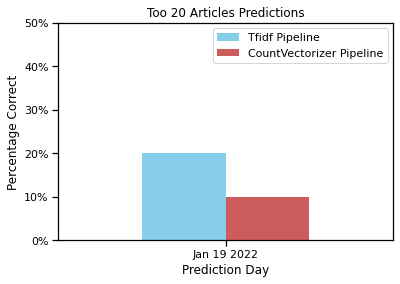

In [243]:
plot_predictions(pred_plot_df)